<a href="https://colab.research.google.com/github/Kh0uloud/Fine-Grained-Sentiment-Analysis-for-Gym-Customer-Feedback/blob/main/Depression_Prediction_From_Tweeter_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil
import json
from glob import glob
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
import re
from pathlib import Path
from dateutil import parser
import ast

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import scipy.stats as stats
import math

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.model_selection import train_test_split
import shap

from statsmodels.api import OLS

tqdm.pandas()

# Unzipping Data

In [ ]:
!apt-get install p7zip-full -y  # Install 7-Zip (only needed once)
!7z x "/content/drive/MyDrive/MentalHealthProject/Dataset_MDDL.zip" -o"/content/data" -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs AMD EPYC 7B12 (830F10),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/MentalHealthProject/                                                     1 file, 8393734330 bytes (8005 MiB)

Extracting archive: /content/drive/MyDrive/MentalHealthProject/Dataset_MDDL.zip
  2% 4096 Open               10% 20480 Open                43% 81920 Open                79% 151552 Open                

In [ ]:
shutil.move("/content/data/Dataset/labeled/positive", "/content/drive/MyDrive/MentalHealthProject/LabeledPos")

'/content/drive/MyDrive/MentalHealthProject/LabeledPos'

In [ ]:
shutil.move("/content/data/Dataset/labeled/negative", "/content/drive/MyDrive/MentalHealthProject/LabeledNeg")

'/content/drive/MyDrive/MentalHealthProject/LabeledNeg'

In [ ]:
shutil.rmtree("/content/data")

# Data

The dataset is the MDDL (Multimodal Dictionary Learning) dataset, designed for depression detection via social media, specifically Twitter. It contains a combination of user profile features, tweet metadata, and timelines of user interactions. This dataset has been used to create two distinct labels: depressed and non-depressed users based on the content of their tweets. <br>

<h4>Structure of the Dataset: </h4>

1.   Users: Each JSON file in this folder contains detailed information about a specific user. Each record includes user profile features (account metadata, profile details, activity statistics, etc.)
2.   Tweets: Each JSON file in this folder contains tweet-level data with information such as the tweet content, sentiment, engagement statistics (like retweets and likes), and metadata.
3.	Timeline: This folder contains multiple rows per file, each representing a tweet from a particular user. These rows contain time-stamped data such as tweet content, engagement, and user interaction metadata.


## Data Extraction

In [ ]:
pos_data = "/content/drive/MyDrive/MentalHealthProject/LabeledPos/data"
files = glob(os.path.join(pos_data, "timeline", "*.json"))

# Read all JSON files and concatenate them
df_timeline_list = [pd.read_json(file, lines=True) for file in tqdm(files)]
df_timeline_pos = pd.concat(df_timeline_list, ignore_index=True)

100%|██████████| 2622/2622 [07:43<00:00,  5.66it/s]


In [ ]:
pos_data = "/content/drive/MyDrive/MentalHealthProject/LabeledPos/data"
files = glob(os.path.join(pos_data, "users", "*.json"))

# Read all JSON files and concatenate them
df_users_list = [pd.read_json(file, lines=True) for file in tqdm(files)]
df_users_pos = pd.concat(df_users_list, ignore_index=True)

100%|██████████| 5899/5899 [04:55<00:00, 19.93it/s]


In [ ]:
neg_data = "/content/drive/MyDrive/MentalHealthProject/LabeledNeg/data"

files = glob(os.path.join(neg_data, "timeline", "*.json"))

non_empty_files = []  # List to store non-empty file names

def process_json_file(file_path):
    """Reads a JSON file, extracts valid JSON objects, and returns a DataFrame."""
    with open(file_path, "r", encoding="utf-8") as file:
        content = file.read().strip()

    # Split based on `{"created_at"`, keeping the delimiter
    objects = re.split(r'(?=\{"created_at")', content)

    json_objects = []
    for obj in objects:
        obj = obj.strip()
        if obj:
            try:
                json_objects.append(json.loads(obj))
            except json.JSONDecodeError:
                continue  # Skip invalid JSON objects

    if json_objects:
        non_empty_files.append(file_path)  # Store non-empty file names

    return pd.DataFrame(json_objects) if json_objects else pd.DataFrame()

def process_multiple_json_files(file_paths):
    """Processes multiple JSON files and concatenates the resulting DataFrames."""
    dfs = [process_json_file(file) for file in tqdm(file_paths)]
    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

# Process all files
df_timeline_neg = process_multiple_json_files(files)

100%|██████████| 2000/2000 [1:52:47<00:00,  3.38s/it]
<ipython-input-3-b103485892f1>:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()


In [ ]:
neg_data = "/content/drive/MyDrive/MentalHealthProject/LabeledNeg/data"
files = glob(os.path.join(neg_data, "users", "*.json"))
df_users_list = []
for file in tqdm(files):
    try:
        df_users_list.append(pd.read_json(file, lines=True))
    except:
        print(f"file ({os.path.basename(file)}) couldn't be read")
        continue
df_users_neg = pd.concat(df_users_list, ignore_index=True)

100%|██████████| 5160/5160 [07:34<00:00, 11.34it/s]


In [ ]:
print(f"df_timeline columns: {df_timeline.columns}")
print('---------------- \n')

print(f"df_tweet columns: {df_tweet.columns}")
print('---------------- \n')

print(f"df_users columns: {df_users.columns}")

df_timeline columns: Index(['created_at', 'id', 'id_str', 'text', 'truncated', 'entities', 'source',
       'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str',
       'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place',
       'contributors', 'is_quote_status', 'retweet_count', 'favorite_count',
       'favorited', 'retweeted', 'possibly_sensitive', 'lang',
       'extended_entities', 'retweeted_status', 'quoted_status_id',
       'quoted_status_id_str', 'quoted_status', 'withheld_scope',
       'withheld_copyright', 'withheld_in_countries'],
      dtype='object')
---------------- 

df_tweet columns: Index(['created_at', 'id', 'id_str', 'text', 'truncated', 'entities', 'source',
       'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str',
       'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place',
       'contributors', 'is_quote_status', 'retwee

## Data preprocessing and Features Engineering

### User Data

<table border="1">
  <thead>
    <tr>
      <th>Category</th>
      <th>Potential Features</th>
      <th>Reason for Inclusion</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>User Profile Features</td>
      <td>followers_count, friends_count, statuses_count, listed_count, verified</td>
      <td>Social influence, engagement level</td>
    </tr>
    <tr>
      <td>Behavioral Features</td>
      <td>favourites_count, geo_enabled, profile_use_background_image, default_profile, default_profile_image, has_extended_profile</td>
      <td>Activity and customization trends</td>
    </tr>
    <tr>
      <td>Time-based Features</td>
      <td>created_at, utc_offset, time_zone</td>
      <td>Account age and timezone effects</td>
    </tr>
    <tr>
      <td>Tweet-Based Features</td>
      <td>status (text sentiment score)</td>
      <td>Emotional sentiment of tweets</td>
    </tr>
    <tr>
      <td>Visual & Style Preferences</td>
      <td>profile_background_color, profile_link_color, profile_sidebar_fill_color, profile_text_color</td>
      <td>Color psychology & depression detection</td>
    </tr>
  </tbody>
</table>


#### Collect Users Data from Negative Users (non-depressed) and Positive Users (depressed)
Basic Data Exploration

In [ ]:
df_users_neg['depression'] = False  # Negative Data
df_users_pos['depression'] = True   # Positive Data

In [ ]:
users = pd.concat([df_users_pos, df_users_neg])

# Shuffling rows
users = users.sample(frac=1, random_state=42)
users.shape

(11059, 45)

In [ ]:
# Extract numeric and categorical columns
num_cols = users.select_dtypes(include=[np.number]).columns
cat_cols = users.select_dtypes(exclude=[np.number]).columns

In [ ]:
# Summary statistics for numerical features
users[num_cols].describe()

id        id_str  followers_count  friends_count  \
count  1.105900e+04  1.105900e+04     11059.000000   11059.000000   
mean   6.940020e+16  6.940020e+16      1922.818428     878.860476   
std    2.201478e+17  2.201478e+17     13030.652658    3019.073749   
min    1.090400e+04  1.090400e+04         0.000000       0.000000   
25%    2.576247e+08  2.576247e+08       163.000000     148.000000   
50%    9.569353e+08  9.569353e+08       472.000000     360.000000   
75%    2.807765e+09  2.807765e+09      1239.000000     806.000000   
max    8.194569e+17  8.194569e+17    986769.000000  126748.000000   

       listed_count  favourites_count    utc_offset  statuses_count  
count  11059.000000      11059.000000   7424.000000    1.105900e+04  
mean      30.488290       9325.841215 -11824.137931    3.233261e+04  
std      147.757149      20292.786411  19195.717064    7.179868e+04  
min        0.000000          0.000000 -39600.000000    1.000000e+00  
25%        1.000000        275.500000 -28800.000000    2.997500e+03  
50%        5.000000       2132.000000 -18000.000000    1.223800e+04  
75%       20.000000       9430.000000      0.000000    3.614800e+04  
max     8324.000000     356830.000000  46800.000000    2.363105e+06

In [ ]:
# Make sure ids are unique accross the dataframe
print(f"Total number of users: {len(users)}, \nTotal number of unique users: {users.id.nunique()}, \n \nRedundant users ids: \n{users.id.value_counts().loc[lambda x: x > 1]}")
print('-------------------- \n')
# Extract redundant ids, display to check if they correspond to the same persons
redundant_ids = users.id.value_counts().loc[lambda x: x > 1].index.tolist()
print(users[users["id"].isin(redundant_ids)][['id', 'name', 'screen_name', 'location', 'depression']])

# Remove rows with the redundant ids, as they represent conflicting info (depression)
users = users[~users["id"].isin(redundant_ids)]

Total number of users: 11059, 
Total number of unique users: 11055, 
 
Redundant users ids: 
id
332432312     2
295636725     2
20022913      2
1200392156    2
Name: count, dtype: int64
-------------------- 

              id               name    screen_name  \
1790  1200392156          Kana | カナ  Rotten_Velvet   
3821    20022913  Justin/Cyberwaste  iAmCyberwaste   
102     20022913       Justin Lutze  iAmCyberwaste   
2646   332432312             kagome        chxrnxe   
4409  1200392156        ( ͡° ͜ʖ ͡°)  Rotten_Velvet   
4959   295636725      wretched king    ZaPrototype   
2803   295636725  Yo Favorite Bitch    ZaPrototype   
4918   332432312             kagome        chxrnxe   

                        location  depression  
1790    Perth, Western Australia       False  
3821  New South Wales, Australia       False  
102   New South Wales, Australia        True  
2646                                    True  
4409    Perth, Western Australia        True  
4959                  

In [ ]:
# Delete irrelevant columns
print(users.protected.unique(), users.contributors_enabled.unique(), users.is_translator.unique(), users.following.unique(), users.follow_request_sent.unique(), users.notifications.unique())

users = users.drop(['id_str', 'protected', 'contributors_enabled', 'is_translator', 'following', 'follow_request_sent', 'notifications'], axis=1)

[False] [False] [False] [0.0 nan] [False] [0.0 nan]


In [ ]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11051 entries, 3643 to 1371
Data columns (total 38 columns):
 #   Column                              Non-Null Count  Dtype              
---  ------                              --------------  -----              
 0   id                                  11051 non-null  int64              
 1   name                                11051 non-null  object             
 2   screen_name                         11051 non-null  object             
 3   location                            11051 non-null  object             
 4   profile_location                    541 non-null    object             
 5   description                         11051 non-null  object             
 6   url                                 4280 non-null   object             
 7   entities                            11051 non-null  object             
 8   followers_count                     11051 non-null  int64              
 9   friends_count                       11051 

#### Encode Colors for Analysis

<table border="1">
  <thead>
    <tr>
      <th>Category</th>
      <th>Potential Features</th>
      <th>Reason for Inclusion</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Visual & Style Preferences</td>
      <td>profile_background_color, <br> profile_link_color, <br> profile_sidebar_border_color, <br> profile_sidebar_fill_color, <br> profile_text_color</td>
      <td>Color psychology & depression detection</td>
    </tr>
  </tbody>
</table>


Conclusion: Given the focus on mental health prediction, we will start with profile_background_color. It is likely to be the most psychologically meaningful, plus it's highly correlated with profile_sidebar_border_color_brightness and profile_sidebar_fill_color_brightness.

In [ ]:
# Convert Numeric Values to Hex Format in color columns
# because Some values are integers rather than hexadecimal color codes

def convert_to_hex(color):
    if pd.isna(color) or color in [np.inf, -np.inf]:  # Handle NaN values
        return "ffffff"  # Default color (white)
    elif isinstance(color, (int, float)):
        try:
          return f"{int(color):06X}"  # Convert integer to hex (6-character)
        except :
          print(color)
          print(f"{int(color):06X}")
    elif isinstance(color, str):
        return color.lower()  # Ensure consistency
    else:
        return "ffffff"  # Default fallback

users["profile_background_color"] = users["profile_background_color"].apply(convert_to_hex)

users["profile_link_color"] = users["profile_link_color"].apply(convert_to_hex)

users["profile_sidebar_border_color"] = users["profile_sidebar_border_color"].apply(convert_to_hex)

users["profile_sidebar_fill_color"] = users["profile_sidebar_fill_color"].apply(convert_to_hex)

users["profile_text_color"] = users["profile_text_color"].apply(convert_to_hex)

In [ ]:
# Convert hex colors to RGB values

def hex_to_rgb(hex_color):
    """Converts a hex color code (string) into an RGB tuple."""
    if isinstance(hex_color, str):
        hex_color = hex_color.lstrip('#')  # Remove '#' if present
        return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))  # RGB
    else:
        return (0, 0, 0)  # Default to black for invalid color codes

for color_column in ['profile_background_color', 'profile_link_color',
                     'profile_sidebar_border_color', 'profile_sidebar_fill_color',
                     'profile_text_color']:
    users[[f'{color_column}_r', f'{color_column}_g', f'{color_column}_b']] = \
        users[color_column].apply(lambda x: pd.Series(hex_to_rgb(x)))

In [ ]:
# Color brightness (to analyze psychological effects)

def calculate_brightness(r, g, b):
    return 0.299 * r + 0.587 * g + 0.114 * b

for color_column in ['profile_background_color', 'profile_link_color',
                     'profile_sidebar_border_color', 'profile_sidebar_fill_color',
                     'profile_text_color']:
    users[f'{color_column}_brightness'] = users.apply(
        lambda row: calculate_brightness(row[f'{color_column}_r'], row[f'{color_column}_g'], row[f'{color_column}_b']), axis=1
    )

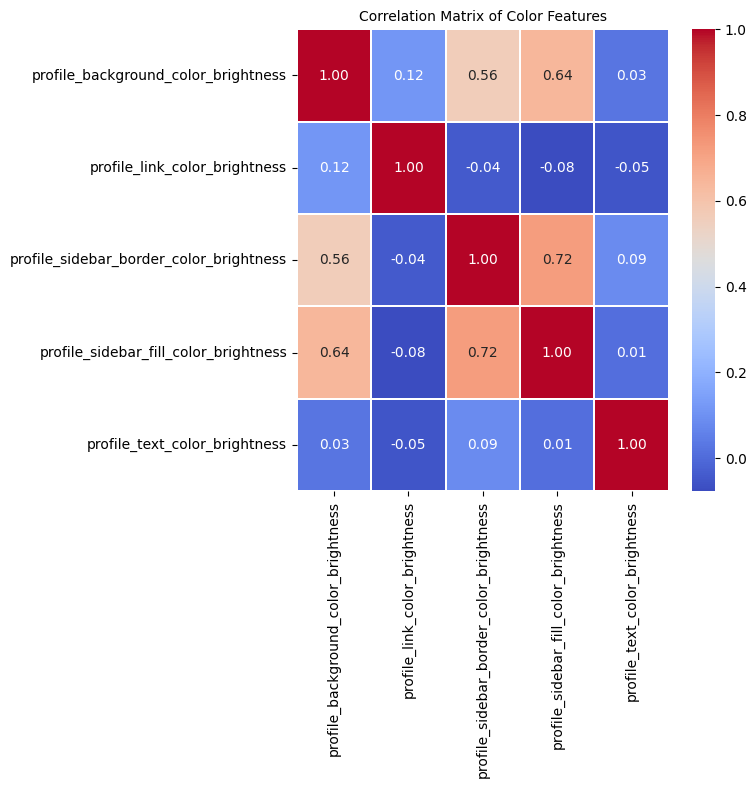

In [ ]:
# List of color-related columns (RGB components for each color)
color_columns = [
    'profile_background_color_brightness',
    'profile_link_color_brightness',
    'profile_sidebar_border_color_brightness',
    'profile_sidebar_fill_color_brightness',
    'profile_text_color_brightness'
]

# Compute the correlation matrix
corr_matrix = users[color_columns].corr()

plt.figure(figsize=(6, 6))

# Create a heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.3)
plt.title('Correlation Matrix of Color Features', fontsize=10)
plt.show()

In [ ]:
users = users.drop(['profile_background_color_r', 'profile_background_color_g', 'profile_background_color_b',
    'profile_link_color_r', 'profile_link_color_g', 'profile_link_color_b',
    'profile_sidebar_border_color_r', 'profile_sidebar_border_color_g', 'profile_sidebar_border_color_b',
    'profile_sidebar_fill_color_r', 'profile_sidebar_fill_color_g', 'profile_sidebar_fill_color_b',
    'profile_text_color_r', 'profile_text_color_g', 'profile_text_color_b',
    'profile_link_color_brightness',
    'profile_sidebar_border_color_brightness',
    'profile_sidebar_fill_color_brightness',
    'profile_text_color_brightness'
    ], axis=1)

#### Further Preprocessing Needed

*   Account Age
*   Convert Categorical to Numerical
*   Normalize Continuous Variables
*   Extract Numerical Values from Dates (If required)
*   Process Text Data (Later)


In [ ]:
# Account Age
users["account_age"] = (pd.Timestamp.now(tz="UTC") - users["created_at"]).dt.days / 365
print(f"The account_age min value (in years): {users.account_age.min()}, \nThe account_age max value (in years): {users.account_age.max()}")

The account_age min value (in years): 8.224657534246575, 
The account_age max value (in years): 18.44109589041096


In [ ]:
# Get Numeric Columns
numeric_columns = users.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'id' in numeric_columns:
    numeric_columns.remove('id')
print(f"Numeric Columns: {numeric_columns}")

# Scaling Numeric Columns (MinMax)
scaler = MinMaxScaler()
users[numeric_columns] = scaler.fit_transform(users[numeric_columns])

Numeric Columns: ['followers_count', 'friends_count', 'listed_count', 'favourites_count', 'utc_offset', 'statuses_count', 'profile_background_color_brightness', 'account_age']


In [ ]:
# Convert Boolean Columns to 0 or 1
bool_columns = users.select_dtypes(include=['bool']).columns.tolist()
print(f"boolean Columns: {bool_columns}")

users[bool_columns] = users[bool_columns].astype(int)

boolean Columns: ['geo_enabled', 'verified', 'is_translation_enabled', 'profile_background_tile', 'profile_use_background_image', 'has_extended_profile', 'default_profile', 'default_profile_image', 'depression']


In [ ]:
users["creation_year"] = users["created_at"].dt.year

#### Feature Selection
<table border="1" style="border-collapse: collapse; width: 100%; text-align: left;">
  <thead>
    <tr style="background-color: #f2f2f2;">
      <th style="padding: 8px;">Category</th>
      <th style="padding: 8px;">Features</th>
      <th style="padding: 8px;">Justification</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="padding: 8px;">User Influence & Engagement</td>
      <td style="padding: 8px;">followers_count, <br> friends_count, <br> listed_count, <br> statuses_count, <br> favourites_count</td>
      <td style="padding: 8px;">Social engagement level— <br> People with higher/lower engagement may exhibit different online <br>behaviors related to mental health.</td>
    </tr>
    <tr>
      <td style="padding: 8px;">Account Information</td>
      <td style="padding: 8px;">account_age</td>
      <td style="padding: 8px;">Account age—<br> Older vs. newer accounts may reflect different behavioral patterns.</td>
    </tr>
    <tr>
      <td style="padding: 8px;">Behavioral Features</td>
      <td style="padding: 8px;">geo_enabled, <br> profile_use_background_image, <br> has_extended_profile, <br> default_profile, <br> default_profile_image</td>
      <td style="padding: 8px;">Customization & privacy behavior— <br> These may indicate user engagement and personality.</td>
    </tr>
    <tr>
      <td style="padding: 8px;">Visual Preferences</td>
      <td style="padding: 8px;">profile_background_color_brightness</td>
      <td style="padding: 8px;">Color psychology— <br>
       Colors can indicate emotions and psychological states.</td>
    </tr>
    <tr>
      <td style="padding: 8px;">Verified Status</td>
      <td style="padding: 8px;">verified</td>
      <td style="padding: 8px;">Social credibility— <br> Verified users may behave differently online.</td>
    </tr>
    <tr>
      <td style="padding: 8px;">Language & Translation</td>
      <td style="padding: 8px;">is_translation_enabled </td>
      <td style="padding: 8px;">Global vs. local engagement— <br> Multilingual users might have different social patterns.</td>
    </tr>
    <tr>
      <td style="padding: 8px;">Target Variable</td>
      <td style="padding: 8px;">depression</td>
      <td style="padding: 8px;">Our regression target— <br> Deppressed or not</td>
    </tr>
  </tbody>
</table>


In [ ]:
num_cols = ['creation_year', 'geo_enabled', 'profile_use_background_image', 'has_extended_profile', 'default_profile',
    'default_profile_image', 'verified', 'is_translation_enabled']

# Define subplot layout
cols = 3  # Number of columns
rows = math.ceil(len(num_cols) / cols)  # Number of rows

fig = make_subplots(
    rows=rows, cols=cols,
    subplot_titles=[f"Avg {var} vs Depression" for var in num_cols],
    horizontal_spacing=0.1,  # Adjust spacing
    vertical_spacing=0.1
)

# Add each variable's plot to the figure
for idx, var in enumerate(num_cols):
    row = idx // cols + 1
    col = idx % cols + 1

    variable_count = users.groupby([var, 'depression'])[var].count().unstack()

    # Add bars for each depression category
    for depression_status in [0, 1]:
        fig.add_trace(
            go.Bar(
                x=variable_count.index,
                y=variable_count[depression_status],
                name=f"Depression: {'True' if depression_status == 1 else 'False'}",
                text=variable_count[depression_status].round(2),  # Round for better display
                textposition='outside',
                width=0.2,
                marker=dict(line=dict(width=2, color='rgba(0,0,0,1)'), opacity=1)
            ),
            row=row, col=col
            )

# Update layout
fig.update_layout(
    title="Comparison of Numerical Features with Depression",
    height=rows * 300,  # Adjust height dynamically
    width=1200,  # Set width for better visibility
    plot_bgcolor='rgba(34, 34, 34, 1)',
    paper_bgcolor='rgba(34, 34, 34, 1)',
    font=dict(color='white'),
    barmode='group',  # Ensures bars for depression=True and False are placed side by side
    showlegend=False
)

fig.show()

In [ ]:
# Numerical columns
num_cols = [
    'followers_count', 'friends_count', 'listed_count', 'favourites_count', 'statuses_count',
    'profile_background_color_brightness', 'account_age'
]

# Define subplot layout
cols = 3  # Number of columns
rows = math.ceil(len(num_cols) / cols)  # Number of rows

fig = make_subplots(
    rows=rows, cols=cols,
    subplot_titles=[f"Avg {var} vs Depression" for var in num_cols],
    horizontal_spacing=0.1,  # Adjust spacing
    vertical_spacing=0.1
)

# Add each variable's plot to the figure
for idx, var in enumerate(num_cols):
    row = idx // cols + 1
    col = idx % cols + 1

    variable_count = users.groupby('depression')[var].mean()

    fig.add_trace(
        go.Bar(
            x=variable_count.index,
            y=variable_count.values,
            marker_color='rgb(156, 39, 176)',
            text=variable_count.round(2),
            textposition='outside',
            width=0.2,
            marker=dict(line=dict(width=1, color='rgba(0,0,0,1)'), opacity=1)
        ),
        row=row, col=col
    )

# Update layout
fig.update_layout(
    title="Comparison of Numerical Features with Depression",
    height=rows * 300,  # Adjust height dynamically
    width=1200,  # Set width for better visibility
    plot_bgcolor='rgba(34, 34, 34, 1)',
    paper_bgcolor='rgba(34, 34, 34, 1)',
    font=dict(color='white'),
    showlegend=False
)

fig.show()

In [ ]:
# Extract numeric and categorical columns
num_cols = users.select_dtypes(include=[np.number]).columns

# Assuming `train_data` is your DataFrame and `num_cols` is a list of numerical columns
corr_matrix = users[num_cols].corr()

fig = go.Figure(data=go.Heatmap(
    z=corr_matrix.values,
    x=corr_matrix.columns,
    y=corr_matrix.columns,
    colorscale='Viridis',
    colorbar=dict(title='Correlation'),
))

fig.update_layout(
    title='Correlation Heatmap',
    xaxis_title='Features',
    yaxis_title='Features',
    width=800,
    height=700,
    template='plotly_dark',  # Use dark theme
)

fig.show()

In [ ]:
users = users[['id', 'followers_count', 'friends_count', 'listed_count', 'favourites_count', 'statuses_count', 'geo_enabled', 'profile_use_background_image', 'has_extended_profile', 'default_profile', 'default_profile_image', 'profile_background_color_brightness', 'account_age', 'verified', 'is_translation_enabled', 'depression']]

In [ ]:
users

id  followers_count  friends_count  listed_count  \
3643          1057022347         0.000471       0.004931      0.000240   
1636           171999132         0.000255       0.016718      0.000601   
4703  751907980405198848         0.001638       0.000828      0.005766   
2992          2236408118         0.005013       0.036608      0.000841   
5502           434369401         0.000197       0.002477      0.000120   
...                  ...              ...            ...           ...   
5734           322279406         0.000933       0.003038      0.000240   
5191          1895493180         0.007947       0.041326      0.002883   
5390          2317448645         0.000643       0.006225      0.000120   
860             21038530         0.000003       0.000039      0.000000   
1371  760734453102551040         0.001782       0.001160      0.009010   

      favourites_count  statuses_count  geo_enabled  \
3643          0.005445        0.002718            0   
1636          0.001973        0.000604            0   
4703          0.099888        0.006630            0   
2992          0.005770        0.002221            0   
5502          0.009385        0.008613            0   
...                ...             ...          ...   
5734          0.024547        0.011156            1   
5191          0.049556        0.017103            1   
5390          0.002508        0.003144            0   
860           0.000000        0.000003            0   
1371          0.046266        0.008351            0   

      profile_use_background_image  has_extended_profile  default_profile  \
3643                             1                     1                0   
1636                             1                     0                0   
4703                             0                     0                0   
2992                             1                     0                0   
5502                             1                     0                1   
...                            ...                   ...              ...   
5734                             0                     1                0   
5191                             1                     1                0   
5390                             1                     0                1   
860                              1                     0                1   
1371                             0                     1                0   

      default_profile_image  profile_background_color_brightness  account_age  \
3643                      0                             0.106498     0.394208   
1636                      0                             0.282984     0.632877   
4703                      0                             0.000000     0.049879   
2992                      0                             1.000000     0.303298   
5502                      0                             0.842118     0.498525   
...                     ...                                  ...          ...   
5734                      0                             0.486122     0.544382   
5191                      0                             0.842118     0.323679   
5390                      0                             0.842118     0.288549   
860                       1                             0.842118     0.773934   
1371                      0                             0.000000     0.043443   

      verified  is_translation_enabled  depression  
3643         0                       0           0  
1636         0                       0           0  
4703         0                       0           0  
2992         0                       0           1  
5502         0                       0           1  
...        ...                     ...         ...  
5734         0                       0           1  
5191         0                       0           1  
5390         0                       0           1  
860          0                       0      

In [ ]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11051 entries, 3643 to 1371
Data columns (total 16 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   11051 non-null  int64  
 1   followers_count                      11051 non-null  float64
 2   friends_count                        11051 non-null  float64
 3   listed_count                         11051 non-null  float64
 4   favourites_count                     11051 non-null  float64
 5   statuses_count                       11051 non-null  float64
 6   geo_enabled                          11051 non-null  int64  
 7   profile_use_background_image         11051 non-null  int64  
 8   has_extended_profile                 11051 non-null  int64  
 9   default_profile                      11051 non-null  int64  
 10  default_profile_image                11051 non-null  int64  
 11  profile_background_color_bright

### Timeline Data

#### Timeline




##### Timeline Positive Data

In [ ]:
df_timeline_pos["user_id"] = df_timeline_pos["user"].progress_apply(lambda x: x.get("id") if isinstance(x, dict) else None)
print(f"\n{df_timeline_pos.user_id.nunique()}")

100%|██████████| 506158/506158 [00:01<00:00, 408878.25it/s]


2512


In [ ]:
df_timeline_pos.columns

Index(['created_at', 'id', 'id_str', 'text', 'truncated', 'entities', 'source',
       'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str',
       'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place',
       'contributors', 'is_quote_status', 'retweet_count', 'favorite_count',
       'favorited', 'retweeted', 'possibly_sensitive', 'lang',
       'extended_entities', 'retweeted_status', 'quoted_status_id',
       'quoted_status_id_str', 'quoted_status', 'withheld_scope',
       'withheld_copyright', 'withheld_in_countries', 'user_id'],
      dtype='object')

In [ ]:
df_timeline_pos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506158 entries, 0 to 506157
Data columns (total 33 columns):
 #   Column                     Non-Null Count   Dtype              
---  ------                     --------------   -----              
 0   created_at                 506158 non-null  datetime64[ns, UTC]
 1   id                         506158 non-null  int64              
 2   id_str                     506158 non-null  int64              
 3   text                       506158 non-null  object             
 4   truncated                  506158 non-null  bool               
 5   entities                   506158 non-null  object             
 6   source                     506158 non-null  object             
 7   in_reply_to_status_id      117609 non-null  float64            
 8   in_reply_to_status_id_str  117609 non-null  float64            
 9   in_reply_to_user_id        135908 non-null  float64            
 10  in_reply_to_user_id_str    135908 non-null  float64     

In [ ]:
# Number of duplicate rows
red_rows_all_data = df_timeline_pos.duplicated(['created_at', 'id', 'id_str', 'text', 'truncated', 'source',
                                                'in_reply_to_status_id', 'in_reply_to_status_id_str',
                                                'in_reply_to_user_id', 'in_reply_to_user_id_str',
                                                'in_reply_to_screen_name', 'contributors', 'is_quote_status',
                                                'retweet_count', 'favorite_count', 'favorited', 'retweeted',
                                                'possibly_sensitive', 'lang', 'quoted_status_id', 'quoted_status_id_str',
                                                'withheld_scope', 'withheld_copyright', 'user_id']).sum()
print(f"Number of redundant rows: {red_rows_all_data}")

red_rows = df_timeline_pos.duplicated(subset=['user_id', 'text']).sum()
print(f"Number of redundant rows (on user_id and tweet): {red_rows}")

df_timeline_pos = df_timeline_pos.drop_duplicates(subset=["user_id", "text"])

Number of redundant rows: 15442
Number of redundant rows (on user_id and tweet): 18099


In [ ]:
df_timeline_pos = df_timeline_pos[df_timeline_pos['lang']=='en']

In [ ]:
df_timeline_pos.truncated.nunique(), df_timeline_pos.source.nunique(), df_timeline_pos.contributors.nunique(), df_timeline_pos.possibly_sensitive.nunique(), df_timeline_pos.lang.nunique(), df_timeline_pos.withheld_scope.nunique(), df_timeline_pos.withheld_copyright.nunique()

(1, 263, 0, 2, 1, 1, 1)

In [ ]:
df_timeline_pos.drop(['contributors', 'lang', 'withheld_scope', 'user',
                      'withheld_copyright', 'withheld_in_countries'], axis=1, inplace=True)

<ipython-input-81-936334cb45e6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_timeline_pos.drop(['contributors', 'lang', 'withheld_scope', 'user',


##### Timeline Negative Data

In [ ]:
df_timeline_neg["user"] = df_timeline_neg["user"].progress_apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df_timeline_neg["user_id"] = df_timeline_neg["user"].progress_apply(lambda x: x.get("id") if isinstance(x, dict) else None)
print(df_timeline_neg["user_id"].nunique())

<ipython-input-3-ed3f5068f101>:2: DtypeWarning: Columns (13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_timeline_neg1 = pd.read_csv(save_path1)
<ipython-input-3-ed3f5068f101>:5: DtypeWarning: Columns (13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_timeline_neg2 = pd.read_csv(save_path2)
<ipython-input-3-ed3f5068f101>:8: DtypeWarning: Columns (27,28,29) have mixed types. Specify dtype option on import or set low_memory=False.
  df_timeline_neg3 = pd.read_csv(save_path3)
100%|██████████| 2711606/2711606 [00:03<00:00, 727344.70it/s]

3966


In [ ]:
# Number of duplicate rows
red_rows_all_data = df_timeline_neg.duplicated(['created_at', 'id', 'id_str', 'text', 'truncated', 'entities',
                                       'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str',
                                       'in_reply_to_user_id', 'in_reply_to_user_id_str',
                                       'in_reply_to_screen_name', 'geo', 'coordinates', 'place',
                                       'contributors', 'is_quote_status', 'retweet_count', 'favorite_count',
                                       'favorited', 'retweeted', 'possibly_sensitive', 'lang',
                                       'extended_entities', 'quoted_status_id', 'quoted_status_id_str',
                                       'withheld_scope', 'withheld_copyright', 'withheld_in_countries',
                                       'user_id']).sum()
print(f"Number of redundant rows: {red_rows_all_data}")

red_rows = df_timeline_neg.duplicated(subset=["user_id", "text"]).sum()
print(f"Number of redundant rows (on user_id and tweet): {red_rows}")

df_timeline_neg = df_timeline_neg.drop_duplicates(subset=["user_id", "text"])

Number of redundant rows: 763312
Number of redundant rows (on user_id and tweet): 1023645


In [ ]:
df_timeline_neg = df_timeline_neg[df_timeline_neg['lang']=='en']

In [ ]:
df_timeline_neg.columns

Index(['created_at', 'id', 'id_str', 'text', 'truncated', 'entities', 'source',
       'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str',
       'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place',
       'contributors', 'is_quote_status', 'retweet_count', 'favorite_count',
       'favorited', 'retweeted', 'possibly_sensitive', 'lang',
       'extended_entities', 'quoted_status_id', 'quoted_status_id_str',
       'withheld_scope', 'withheld_copyright', 'withheld_in_countries',
       'user_id'],
      dtype='object')

In [ ]:
df_timeline_neg.truncated.nunique(), df_timeline_neg.entities.nunique(), df_timeline_neg.source.nunique(), df_timeline_neg.geo.nunique(), df_timeline_neg.place.nunique(), df_timeline_neg.contributors.nunique(), df_timeline_neg.possibly_sensitive.nunique(), df_timeline_neg.lang.nunique(), df_timeline_neg.withheld_scope.nunique(), df_timeline_neg.withheld_copyright.nunique(), df_timeline_neg.withheld_in_countries.nunique(),

(2, 399406, 319, 915, 1250, 0, 2, 1, 1, 1, 1)

In [ ]:
df_timeline_neg.drop(['contributors', 'lang', 'withheld_scope', 'user',
                      'withheld_copyright', 'withheld_in_countries'], axis=1, inplace=True)

In [ ]:
df_timeline_neg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1089915 entries, 0 to 1089914
Data columns (total 25 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   created_at                 1089915 non-null  object 
 1   id                         1089915 non-null  int64  
 2   id_str                     1089915 non-null  int64  
 3   text                       1089915 non-null  object 
 4   truncated                  1089915 non-null  bool   
 5   entities                   1089915 non-null  object 
 6   source                     1089566 non-null  object 
 7   in_reply_to_status_id      437243 non-null   float64
 8   in_reply_to_status_id_str  437243 non-null   float64
 9   in_reply_to_user_id        464239 non-null   float64
 10  in_reply_to_user_id_str    464239 non-null   float64
 11  in_reply_to_screen_name    464239 non-null   object 
 12  geo                        2107 non-null     object 
 13  coordinates 

#### Collect Data from Negative Users (non-depressed) and Positive Users (depressed)

Data Collection and cvs Saving

In [ ]:
df_timeline_neg['depression'] = False  # Negative Data
df_timeline_pos['depression'] = True   # Positive Data

df_timeline = pd.concat([df_timeline_neg, df_timeline_pos])

# Shuffling rows
df_timeline = df_timeline.sample(frac=1, random_state=42)
df_timeline.shape

<ipython-input-82-a899ea551654>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_timeline_pos['depression'] = True   # Positive Data


(1533646, 28)

In [ ]:
# Count the number of rows for each unique user_id for df_timeline_pos
user_counts_pos = df_timeline[df_timeline['depression']==True].groupby('user_id').size().reset_index(name='count')
user_counts_pos = user_counts_pos.sort_values(by='count', ascending=False)

# Count the number of rows for each unique user_id for df_timeline_neg
user_counts_neg = df_timeline[df_timeline['depression']==False].groupby('user_id').size().reset_index(name='count')
user_counts_neg = user_counts_neg.sort_values(by='count', ascending=False)

In [ ]:
user_counts_pos['count'].describe(), user_counts_neg['count'].describe()

(count    2511.000000
 mean      176.714855
 std       256.744771
 min         1.000000
 25%        31.000000
 50%        92.000000
 75%       210.000000
 max      2537.000000
 Name: count, dtype: float64,
 count    3586.000000
 mean      303.936141
 std       461.632668
 min         1.000000
 25%        27.000000
 50%       112.000000
 75%       360.750000
 max      2928.000000
 Name: count, dtype: float64)

In [ ]:
df_timeline.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1533646 entries, 242408 to 121958
Data columns (total 28 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   created_at                 1533646 non-null  object 
 1   id                         1533646 non-null  int64  
 2   id_str                     1533646 non-null  int64  
 3   text                       1533646 non-null  object 
 4   truncated                  1533646 non-null  bool   
 5   entities                   1533646 non-null  object 
 6   source                     1533297 non-null  object 
 7   in_reply_to_status_id      537838 non-null   float64
 8   in_reply_to_status_id_str  537838 non-null   float64
 9   in_reply_to_user_id        580304 non-null   float64
 10  in_reply_to_user_id_str    580304 non-null   float64
 11  in_reply_to_screen_name    580304 non-null   object 
 12  geo                        6274 non-null     object 
 13  coordinates  

#### Feature Engineering

In [ ]:
df_timeline["created_at"] = df_timeline["created_at"].progress_apply(lambda x: x if isinstance(x, pd.Timestamp) else parser.parse(str(x)))
print(df_timeline["created_at"].apply(type).value_counts())

# Step 1: Extract source information and count unique sources per user
def clean_source(df):
    df["source"] = df["source"].str.extract(r'>(.*?)<')
    source_counts = df.groupby("user_id")["source"].nunique().reset_index()
    source_counts.rename(columns={"source": "unique_sources"}, inplace=True)
    return df, source_counts

df_timeline, df_source = clean_source(df_timeline)

# Step 2: Feature Engineering for Varying Features
def compute_aggregates(df):
    return df.groupby("user_id").agg(
        total_retweets=("retweet_count", "sum"),
        total_favorites=("favorite_count", "sum"),
        avg_retweets=("retweet_count", "mean"),
        avg_favorites=("favorite_count", "mean"),
        tweet_count=("text", "count"),
    ).reset_index()

df_agg = compute_aggregates(df_timeline)

# Step 3: Compute Tweet Frequency
def compute_tweet_frequency(df):
    df_sorted = df.sort_values(by=["user_id", "created_at"])
    df_sorted["time_diff"] = df_sorted.groupby("user_id")["created_at"].diff().dt.total_seconds()

    tweet_freq = df_sorted.groupby("user_id").agg(
        mean_time_gap=("time_diff", "mean"),
        median_time_gap=("time_diff", "median"),
        std_time_gap=("time_diff", "std"),
        total_timespan=("created_at", lambda x: (x.max() - x.min()).total_seconds()),
    ).reset_index()

    # Compute total number of tweets per user
    tweet_counts = df_sorted.groupby("user_id")["text"].count()

    # Ensure 'total_timespan' is not zero to avoid division errors
    tweet_freq["tweet_rate"] = tweet_freq.progress_apply(
        lambda row: 1 if row["total_timespan"] == 0 else tweet_counts.get(row["user_id"], 0) / (row["total_timespan"] / 86400),
        axis=1
    )
    #tweet_freq["tweet_rate"] = tweet_freq["total_timespan"].apply(lambda x: 1 if x == 0 else df_sorted.groupby("user_id")["text"].count() / (x / 86400))  # Tweets per day

    return tweet_freq

df_freq = compute_tweet_frequency(df_timeline)

# Step 3: Compute Quote-Based Features
def compute_quote_features(df):
    quote_features = df.groupby("user_id").agg(
        total_quotes=("is_quote_status", "sum"),
        quote_ratio=("is_quote_status", "mean")
    ).reset_index()

    quoted_interactions = df[df["quoted_status_id"].notna()].merge(
        df[["user_id", "depression"]].rename(columns={"user_id": "quoted_status_id", "depression": "quoted_depressed"}),
        on="quoted_status_id", how="left"
    )

    quoted_counts = quoted_interactions.groupby("user_id")["quoted_depressed"].sum().reset_index()
    quoted_counts.rename(columns={"quoted_depressed": "quotes_from_depressed"}, inplace=True)

    total_quotes = quoted_interactions.groupby("user_id")["quoted_depressed"].count().reset_index()
    total_quotes.rename(columns={"quoted_depressed": "total_quotes"}, inplace=True)

    quoted_counts = quoted_counts.merge(total_quotes, on="user_id", how="left")
    quoted_counts["quotes_from_non_depressed"] = quoted_counts["total_quotes"] - quoted_counts["quotes_from_depressed"]

    return quote_features.merge(quoted_counts, on="user_id", how="left")

df_quotes = compute_quote_features(df_timeline)

# Step 4: Compute Interaction-Based Features
def compute_interaction_features(df):
    interactions = df.groupby("user_id")["in_reply_to_user_id"].nunique().reset_index()
    interactions.rename(columns={"in_reply_to_user_id": "unique_interactions"}, inplace=True)

    depressed_interactions = df[df["in_reply_to_user_id"].notna()].merge(
        df[["user_id", "depression"]].rename(columns={"user_id": "in_reply_to_user_id", "depression": "reply_depressed"}),
        on="in_reply_to_user_id", how="left"
    )

    depressed_counts = depressed_interactions.groupby("user_id")["reply_depressed"].sum().reset_index()
    depressed_counts.rename(columns={"reply_depressed": "interactions_with_depressed"}, inplace=True)

    total_interactions = depressed_interactions.groupby("user_id")["reply_depressed"].count().reset_index()
    total_interactions.rename(columns={"reply_depressed": "total_interactions"}, inplace=True)

    depressed_counts = depressed_counts.merge(total_interactions, on="user_id", how="left")
    depressed_counts["interactions_with_non_depressed"] = depressed_counts["total_interactions"] - depressed_counts["interactions_with_depressed"]

    return interactions.merge(depressed_counts, on="user_id", how="left")

df_interactions = compute_interaction_features(df_timeline)

# Step 5: Remove Duplicate Tweets
df_unique = df_timeline.drop_duplicates(subset=["user_id", "text"])


# Merge all processed data
df_final = df_agg.merge(df_freq, on="user_id", how="left")\
                   .merge(df_interactions, on="user_id", how="left")\
                   .merge(df_source, on="user_id", how="left")\
                   .merge(df_quotes, on="user_id", how="left")

# Keep the depression label
df_final = df_final.merge(df_timeline[["user_id", "depression"]].drop_duplicates(), on="user_id", how="left")

# Drop unnecessary columns
df_final.drop(columns=["total_timespan"], inplace=True)

100%|██████████| 1533646/1533646 [02:26<00:00, 10474.90it/s]


created_at
<class 'pandas._libs.tslibs.timestamps.Timestamp'>    1533646
Name: count, dtype: int64


100%|██████████| 6097/6097 [00:00<00:00, 77527.48it/s]


In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6097 entries, 0 to 6096
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   user_id                          6097 non-null   int64  
 1   total_retweets                   6097 non-null   int64  
 2   total_favorites                  6097 non-null   int64  
 3   avg_retweets                     6097 non-null   float64
 4   avg_favorites                    6097 non-null   float64
 5   tweet_count                      6097 non-null   int64  
 6   mean_time_gap                    5922 non-null   float64
 7   median_time_gap                  5922 non-null   float64
 8   std_time_gap                     5817 non-null   float64
 9   tweet_rate                       6097 non-null   float64
 10  unique_interactions              6097 non-null   int64  
 11  interactions_with_depressed      5041 non-null   object 
 12  total_interactions  

In [ ]:
# Fill 'mean_time_gap' with the mean value of people with the same depression condition (Only one value was missing)
df_final['mean_time_gap'] = df_final.groupby('depression')['mean_time_gap'].transform(lambda x: x.fillna(x.mean()))
df_final['median_time_gap'] = df_final.groupby('depression')['median_time_gap'].transform(lambda x: x.fillna(x.mean()))
df_final['std_time_gap'] = df_final.groupby('depression')['std_time_gap'].transform(lambda x: x.fillna(x.mean()))

# Fill nan values in 'interactions_with_depressed', 'total_interactions', and 'interactions_with_non_depressed' with 0 (There were no interactions)
df_final['interactions_with_depressed'] = df_final['interactions_with_depressed'].fillna(0)
df_final['total_interactions'] = df_final['total_interactions'].fillna(0)
df_final['interactions_with_non_depressed'] = df_final['interactions_with_non_depressed'].fillna(0)

# Drop the 'quotes_from_depressed' and 'quotes_from_non_depressed' columns (we can also fill with 0; no interactions)
df_final = df_final.drop(columns=['quotes_from_depressed', 'total_quotes_y', 'quotes_from_non_depressed'])

"""
df_final['quotes_from_depressed'] = df_final['quotes_from_depressed'].fillna(0)
df_final['total_quotes_y'] = df_final['total_quotes_y'].fillna(0)
df_final['quotes_from_non_depressed'] = df_final['quotes_from_non_depressed'].fillna(0)
"""

<ipython-input-8-6b6f6c6e2d04>:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_final['interactions_with_depressed'] = df_final['interactions_with_depressed'].fillna(0)
<ipython-input-8-6b6f6c6e2d04>:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_final['interactions_with_non_depressed'] = df_final['interactions_with_non_depressed'].fillna(0)


"\ndf_final['quotes_from_depressed'] = df_final['quotes_from_depressed'].fillna(0)\ndf_final['total_quotes_y'] = df_final['total_quotes_y'].fillna(0)\ndf_final['quotes_from_non_depressed'] = df_final['quotes_from_non_depressed'].fillna(0)\n"

#### Data Exploration

In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6097 entries, 0 to 6096
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   user_id                          6097 non-null   int64  
 1   total_retweets                   6097 non-null   int64  
 2   total_favorites                  6097 non-null   int64  
 3   avg_retweets                     6097 non-null   float64
 4   avg_favorites                    6097 non-null   float64
 5   tweet_count                      6097 non-null   int64  
 6   mean_time_gap                    6097 non-null   float64
 7   median_time_gap                  6097 non-null   float64
 8   std_time_gap                     6097 non-null   float64
 9   tweet_rate                       6097 non-null   float64
 10  unique_interactions              6097 non-null   int64  
 11  interactions_with_depressed      6097 non-null   int64  
 12  total_interactions  

In [ ]:
# Extract numeric and categorical columns
num_cols = df_final.select_dtypes(include=[np.number]).columns
cat_cols = df_final.select_dtypes(exclude=[np.number]).columns

In [ ]:
num_cols

Index(['user_id', 'total_retweets', 'total_favorites', 'avg_retweets',
       'avg_favorites', 'tweet_count', 'mean_time_gap', 'median_time_gap',
       'std_time_gap', 'tweet_rate', 'unique_interactions',
       'interactions_with_depressed', 'total_interactions',
       'interactions_with_non_depressed', 'unique_sources', 'total_quotes_x',
       'quote_ratio'],
      dtype='object')

In [ ]:
# Summary statistics for numerical features
df_final[num_cols].describe()

user_id  total_retweets  total_favorites   avg_retweets  \
count  6.097000e+03    6.097000e+03      6097.000000    6097.000000   
mean   7.595613e+16    6.548225e+04       336.788093     366.848800   
std    2.291582e+17    4.412404e+05      4356.195388    2544.205993   
min    1.191300e+04    0.000000e+00         0.000000       0.000000   
25%    2.873977e+08    2.000000e+00         4.000000       0.025157   
50%    1.157452e+09    3.400000e+01        28.000000       0.231011   
75%    2.898422e+09    1.485000e+03       140.000000      14.181604   
max    8.194559e+17    1.205827e+07    283355.000000  126999.115385   

       avg_favorites  tweet_count  mean_time_gap  median_time_gap  \
count    6097.000000  6097.000000   6.097000e+03     6.097000e+03   
mean        1.249189   251.541086   7.217351e+04     4.264866e+04   
std        19.290643   395.458497   1.864587e+05     1.645195e+05   
min         0.000000     1.000000   1.000000e+00     0.000000e+00   
25%         0.069892    29.000000   6.937722e+03     3.210000e+02   
50%         0.307692   102.000000   2.053319e+04     1.888500e+03   
75%         0.888889   280.000000   6.665443e+04     1.589600e+04   
max      1453.102564  2928.000000   5.358080e+06     2.423137e+06   

       std_time_gap     tweet_rate  unique_interactions  \
count  6.097000e+03    6097.000000          6097.000000   
mean   9.757328e+04      57.701129            24.402493   
std    3.575117e+05    2222.225607            66.810997   
min    5.000000e-01       0.000000             0.000000   
25%    1.704939e+04       1.216154             1.000000   
50%    4.079455e+04       4.019831             8.000000   
75%    9.606986e+04      11.993014            25.000000   
max    1.804307e+07  172800.000000          2696.000000   

       interactions_with_depressed  total_interactions  \
count                  6097.000000        6.097000e+03   
mean                    612.233557        1.095861e+04   
std                    8391.474641        9.774250e+04   
min                       0.000000        0.000000e+00   
25%                       0.000000        0.000000e+00   
50%                       0.000000        0.000000e+00   
75%                       0.000000        5.600000e+02   
max                  440208.000000        5.181840e+06   

       interactions_with_non_depressed  unique_sources  total_quotes_x  \
count                     6.097000e+03     6097.000000     6097.000000   
mean                      1.034638e+04        2.079711        3.092176   
std                       9.744603e+04        1.325555       10.947322   
min                       0.000000e+00        0.000000        0.000000   
25%                       0.000000e+00        1.000000        0.000000   
50%                       0.000000e+00        2.000000        0.000000   
75%                       9.000000e+01        3.000000        1.000000   
max                       5.181840e+06       12.000000      299.000000   

       quote_ratio  
count  6097.000000  
mean      0.011853  
std       0.037110  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.007290  
max       1.000000

In [ ]:
df_final[cat_cols].describe()

depression
count        6097
unique          2
top         False
freq         3586

In [ ]:
df_final['depression']= df_final['depression'].astype(int)

# Numerical columns
num_cols = ['total_retweets', 'total_favorites', 'avg_retweets',
            'avg_favorites', 'tweet_count', 'mean_time_gap', 'median_time_gap',
            'std_time_gap', 'tweet_rate', 'unique_interactions',
            'total_interactions', 'unique_sources', 'total_quotes_x', 'quote_ratio']

# Calculate the class distribution (normalize to get the weights)
class_distribution = df_final['depression'].value_counts(normalize=True)
weights = 1 / class_distribution

# Define subplot layout
cols = 3  # Number of columns
rows = math.ceil(len(num_cols) / cols)  # Number of rows

fig = make_subplots(
    rows=rows, cols=cols,
    subplot_titles=[f"Avg {var} vs Depression" for var in num_cols],
    horizontal_spacing=0.1,  # Adjust spacing
    vertical_spacing=0.1
)

# Add each variable's plot to the figure
for idx, var in enumerate(num_cols):
    row = idx // cols + 1
    col = idx % cols + 1

    variable_count = df_final.groupby('depression')[var].mean()

    fig.add_trace(
        go.Bar(
            x=variable_count.index,
            y=variable_count.values,
            marker_color='rgb(156, 39, 176)',
            text=variable_count.round(2),
            textposition='outside',
            width=0.2,
            marker=dict(line=dict(width=1, color='rgba(0,0,0,1)'), opacity=1)
        ),
        row=row, col=col
    )

# Update layout
fig.update_layout(
    title="Comparison of Numerical Features with Depression",
    height=rows * 300,  # Adjust height dynamically
    width=1200,  # Set width for better visibility
    plot_bgcolor='rgba(34, 34, 34, 1)',
    paper_bgcolor='rgba(34, 34, 34, 1)',
    font=dict(color='white'),
    showlegend=False
)

fig.show()

In [ ]:
# Get Numeric Columns
numeric_columns = df_final.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'depression' in numeric_columns:
    numeric_columns.remove('depression')
if 'user_id' in numeric_columns:
    numeric_columns.remove('user_id')
print(f"Numeric Columns: {numeric_columns}")

# Scaling Numeric Columns (MinMax)
scaler = MinMaxScaler()
df_final[numeric_columns] = scaler.fit_transform(df_final[numeric_columns])

# Convert Boolean Columns to 0 or 1
bool_columns = df_final.select_dtypes(include=['bool']).columns.tolist()
print(f"boolean Columns: {bool_columns}")

df_final[bool_columns] = df_final[bool_columns].astype(int)

Numeric Columns: ['total_retweets', 'total_favorites', 'avg_retweets', 'avg_favorites', 'tweet_count', 'mean_time_gap', 'median_time_gap', 'std_time_gap', 'tweet_rate', 'unique_interactions', 'interactions_with_depressed', 'total_interactions', 'interactions_with_non_depressed', 'unique_sources', 'total_quotes_x', 'quote_ratio']
boolean Columns: ['depression']


#### **Structured Metadata;** User Data and timeline concatenation (datasets with preprocessed numerical features)

In [ ]:
users = users[['id', 'followers_count', 'listed_count', 'favourites_count', 'statuses_count', 'has_extended_profile', 'default_profile', 'profile_background_color_brightness', 'account_age', 'depression']]

In [ ]:
df_final.rename(columns={'user_id': 'id'}, inplace=True)

In [ ]:
len(df_final), len(users)

(6097, 11051)

In [ ]:
# Merge the two DataFrames on 'user_id' and 'depression'
merged_df = pd.merge(df_final, users, on=['id', 'depression'], how='inner')

In [ ]:
# Get class distribution
class_distribution = merged_df["depression"].value_counts(normalize=True) * 100

# Print the proportion of each class
class_distribution

depression
0    58.805186
1    41.194814
Name: proportion, dtype: float64

In [ ]:
# Extract numeric and categorical columns
num_cols = merged_df.select_dtypes(include=[np.number]).columns

# Assuming `train_data` is your DataFrame and `num_cols` is a list of numerical columns
corr_matrix = merged_df[num_cols].corr()

fig = go.Figure(data=go.Heatmap(
    z=corr_matrix.values,
    x=corr_matrix.columns,
    y=corr_matrix.columns,
    colorscale='Viridis',
    colorbar=dict(title='Correlation'),
))

fig.update_layout(
    title='Correlation Heatmap',
    xaxis_title='Features',
    yaxis_title='Features',
    width=800,
    height=700,
    template='plotly_dark',  # Use dark theme
)

fig.show()

In [ ]:
merged_df.columns

Index(['id', 'total_retweets', 'total_favorites', 'avg_retweets',
       'avg_favorites', 'tweet_count', 'mean_time_gap', 'median_time_gap',
       'std_time_gap', 'tweet_rate', 'unique_interactions',
       'interactions_with_depressed', 'total_interactions',
       'interactions_with_non_depressed', 'unique_sources', 'total_quotes_x',
       'quote_ratio', 'depression', 'followers_count', 'listed_count',
       'favourites_count', 'statuses_count', 'has_extended_profile',
       'default_profile', 'profile_background_color_brightness',
       'account_age'],
      dtype='object')

In [ ]:
merged_df = merged_df[['id', 'avg_retweets', 'avg_favorites', 'tweet_count',
                       'mean_time_gap', 'tweet_rate', 'unique_interactions',
                       'interactions_with_depressed', 'total_interactions',
                       'unique_sources', 'quote_ratio', 'followers_count',
                       'favourites_count', 'statuses_count', 'has_extended_profile',
                       'profile_background_color_brightness', 'account_age', 'depression']]

# Classification

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import requests
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.ensemble import StackingClassifier, VotingClassifier

## Choice of features from users dataframe is justified by the feature importance analysis from an other experience (which could be chacked in the **"MDDL Dataset"** notebook

**Feature Importance Analysis**

Features which are important in Gradient Boosting, SHAP, and MI, are critical

Features which are important in Gradient Boosting but not in Permutation Importance, might be leading to overfitting: friends_count with importance_mean=0.00048251

Drop Features That Have Low Importance Across All Methods: verified, default_profile_image, profile_use_background_image, is_translation_enabled, geo_enabled


In [ ]:
# Separate features (X) and target (y)
X = users.drop(["id", "depression"], axis=1)
y = users["depression"]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.15, random_state=RANDOM_SEED)

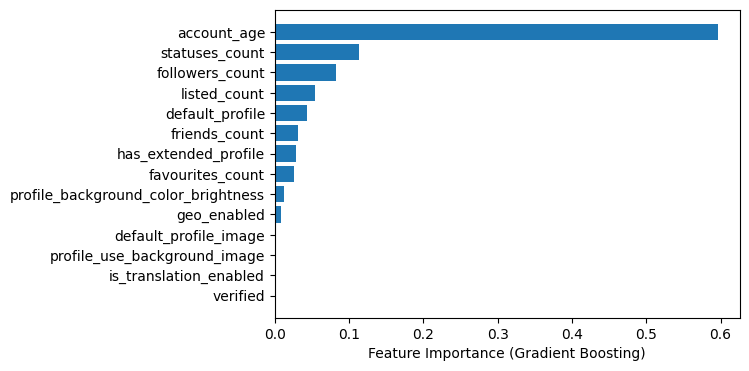

In [ ]:
# Define best hyperparameters
best_params = {
    "n_estimators": 800,
    "learning_rate": 0.01,
    "max_depth": 3,
    "random_state": RANDOM_SEED  # Ensuring reproducibility
}

# Train Gradient Boosting model
gb_model = GradientBoostingClassifier(**best_params)
gb_model.fit(X_train, y_train)

# Extract feature importance
importances = gb_model.feature_importances_
feature_names = X_train.columns

# Sort features by importance
sorted_idx = np.argsort(importances)

# Plot
plt.figure(figsize=(6, 4))
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx])
plt.xlabel("Feature Importance (Gradient Boosting)")
plt.show()

 99%|===================| 9289/9393 [01:49<00:01]       

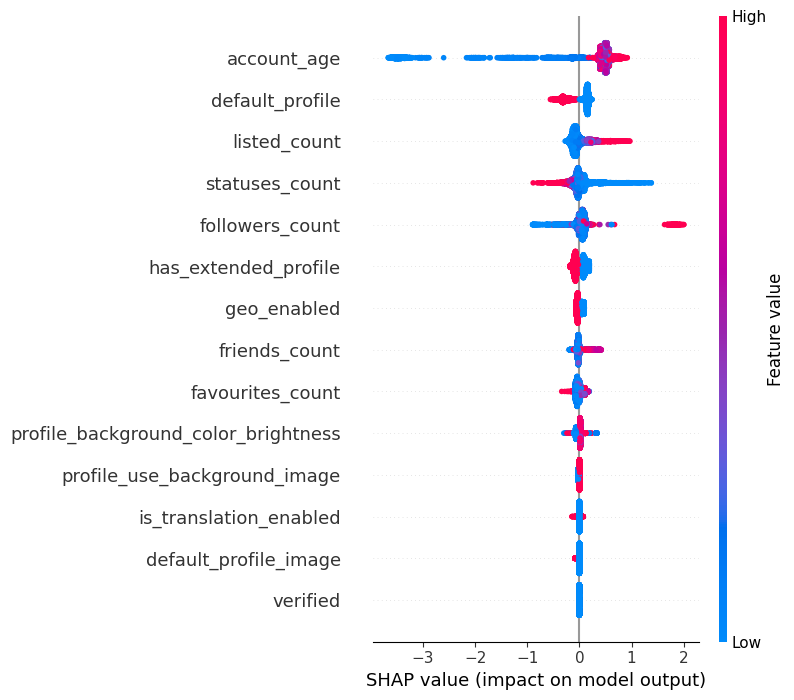

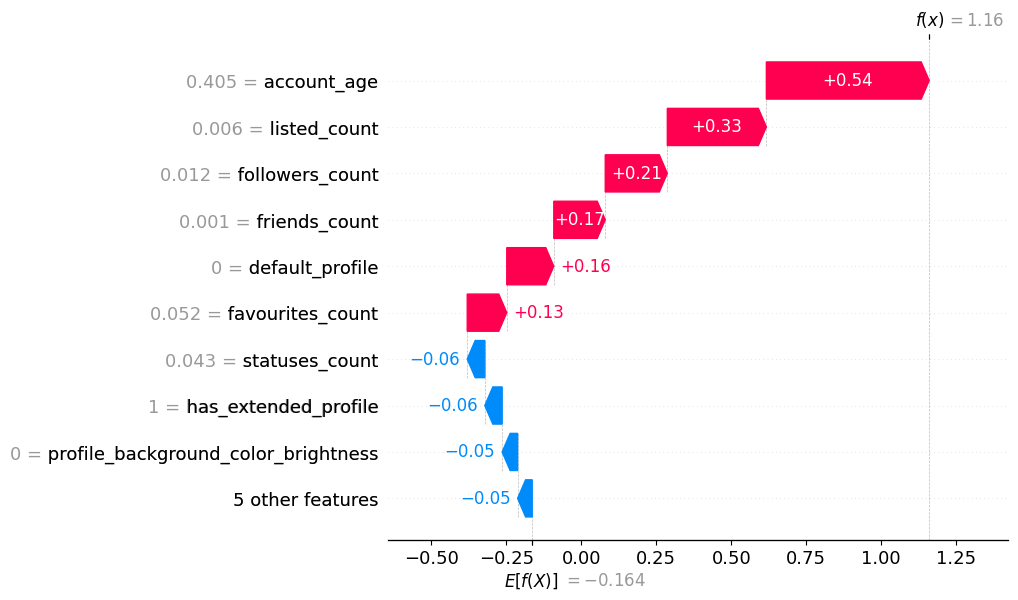

In [ ]:
import shap

# SHAP Explainer
explainer = shap.Explainer(gb_model, X_train)
shap_values = explainer(X_train)

# Summary plot (Global Importance)
shap.summary_plot(shap_values, X_train)

# Waterfall plot (Local Importance for one sample)
shap.waterfall_plot(shap_values[0])

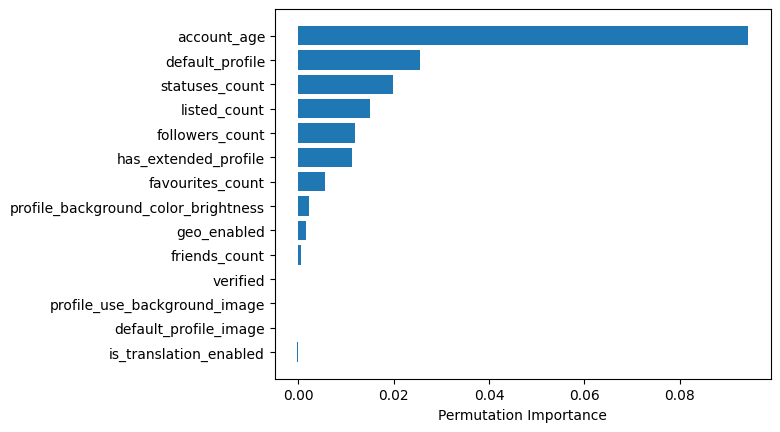

In [ ]:
from sklearn.inspection import permutation_importance

# Compute permutation importance
result = permutation_importance(gb_model, X_test, y_test, n_repeats=10, random_state=42)

# Sort and visualize
sorted_idx = result.importances_mean.argsort()
plt.barh(range(len(sorted_idx)), result.importances_mean[sorted_idx])
plt.yticks(range(len(sorted_idx)), X_train.columns[sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()

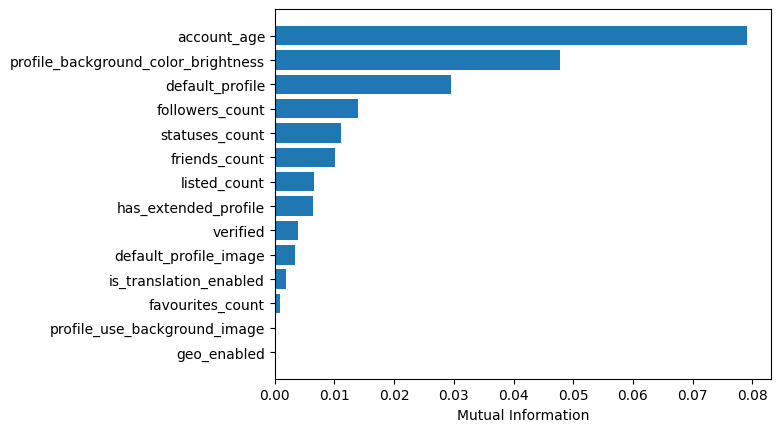

In [ ]:
from sklearn.feature_selection import mutual_info_classif

# Compute mutual information
mi = mutual_info_classif(X_train, y_train)

# Plot
plt.barh(range(len(mi)), np.sort(mi))
plt.yticks(range(len(mi)), X_train.columns[np.argsort(mi)])
plt.xlabel("Mutual Information")
plt.show()

## Using features extracted from 2 datasets: Users and Users’ Tweet Timelines. Best_Accuracy=0.9518

*   Users:
    *   Profile Metadata
*   Users’ Tweet Timelines:
    *   Engagement Patterns
    *   Interaction Patterns
    *   Posting Behaviors



In [ ]:
!pip install optuna
!pip install lime
!pip install eli5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 18.4 MB/s eta 0:00:00


In [ ]:
import optuna
import shap
import eli5
from eli5.sklearn import PermutationImportance
import lime
import lime.lime_tabular

In [ ]:
# Fixing the random seed for reproducibility
RANDOM_SEED = 42

# Separate features (X) and target (y)
def prepare_data(data, test_size=0.15):
    X = data.drop(["id", "depression"], axis=1)
    y = data["depression"]
    return train_test_split(X, y, stratify=y, test_size=test_size, random_state=RANDOM_SEED)

# Define the objective function for Optuna
def objective(trial, model_name, X_train, y_train, X_test, y_test):
    if model_name == "GradientBoosting":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=100),
            "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3, log=True),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
            "random_state": RANDOM_SEED
        }
        model = GradientBoostingClassifier(**params)

    elif model_name == "RandomForest":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=100),
            "max_depth": trial.suggest_categorical("max_depth", [10, 20, 30, None]),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
            "random_state": RANDOM_SEED
        }
        model = RandomForestClassifier(**params)

    elif model_name == "AdaBoost":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 500, step=100),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 1.0, log=True),
            "random_state": RANDOM_SEED
        }
        model = AdaBoostClassifier(**params)

    elif model_name == "DecisionTree":
        params = {
            "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
            "max_depth": trial.suggest_categorical("max_depth", [5, 10, 20, 30, None]),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
            "random_state": RANDOM_SEED
        }
        model = DecisionTreeClassifier(**params)

    elif model_name == "SVM":
        params = {
            "C": trial.suggest_loguniform("C", 0.01, 1000),
            "kernel": trial.suggest_categorical("kernel", ["linear", "rbf"]),
            "gamma": trial.suggest_categorical("gamma", ["scale", "auto", 0.001, 0.01, 0.1, 1]),
            "random_state": RANDOM_SEED
        }
        model = SVC(**params)

    # Train the model
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    # Compute accuracy as objective metric
    return accuracy_score(y_test, predictions)

# Run Bayesian Optimization for each model
def optimize_models(data, n_trials=30):
    X_train, X_test, y_train, y_test = prepare_data(data)

    models = ["SVM", "GradientBoosting", "RandomForest", "AdaBoost", "DecisionTree"]
    best_results = []

    for model_name in tqdm(models):
        print(f"\nOptimizing {model_name}...")

        study = optuna.create_study(direction="maximize")
        study.optimize(lambda trial: objective(trial, model_name, X_train, y_train, X_test, y_test), n_trials=n_trials)

        print(f"Best Params for {model_name}: {study.best_params}\nBest Accuracy: {study.best_value:.4f}")

        best_results.append({
            "Model": model_name,
            "Best Params": study.best_params,
            "Best Accuracy": study.best_value
        })

    return pd.DataFrame(best_results)

In [ ]:
# Run the optimization
optimized_results = optimize_models(merged_df, n_trials=70)

  0%|          | 0/5 [00:00<?, ?it/s][I 2025-04-02 14:36:12,767] A new study created in memory with name: no-name-f66ce3fa-22e2-4349-bf97-b72502186bb8
<ipython-input-45-74cc093d7e2c>:56: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.




Optimizing SVM...


[I 2025-04-02 14:36:14,811] Trial 0 finished with value: 0.6816192560175055 and parameters: {'C': 0.780169100233999, 'kernel': 'linear', 'gamma': 0.001}. Best is trial 0 with value: 0.6816192560175055.
<ipython-input-45-74cc093d7e2c>:56: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-04-02 14:36:17,226] Trial 1 finished with value: 0.8238512035010941 and parameters: {'C': 485.795768328385, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 1 with value: 0.8238512035010941.
<ipython-input-45-74cc093d7e2c>:56: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-04-02 14:36:18,537] Trial 2 finished with value: 0.7691466083150985 and parameters: {'C': 590.1658485

Best Params for SVM: {'C': 991.8577626252073, 'kernel': 'rbf', 'gamma': 1}
Best Accuracy: 0.8490

Optimizing GradientBoosting...


[I 2025-04-02 14:40:34,302] Trial 0 finished with value: 0.937636761487965 and parameters: {'n_estimators': 800, 'learning_rate': 0.03997703436633295, 'max_depth': 10, 'subsample': 0.8972547834705875, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.937636761487965.
[I 2025-04-02 14:40:42,079] Trial 1 finished with value: 0.9234135667396062 and parameters: {'n_estimators': 100, 'learning_rate': 0.004648196905680108, 'max_depth': 10, 'subsample': 0.9295825019698996, 'min_samples_split': 8, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.937636761487965.
[I 2025-04-02 14:40:55,477] Trial 2 finished with value: 0.9332603938730853 and parameters: {'n_estimators': 300, 'learning_rate': 0.007546455795492525, 'max_depth': 7, 'subsample': 0.5629760027073899, 'min_samples_split': 4, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.937636761487965.
[I 2025-04-02 14:41:27,388] Trial 3 finished with value: 0.9442013129102844 and parameters: {'n_estimators': 

Best Params for GradientBoosting: {'n_estimators': 1000, 'learning_rate': 0.22132944375008318, 'max_depth': 5, 'subsample': 0.7098092451187741, 'min_samples_split': 3, 'min_samples_leaf': 4}
Best Accuracy: 0.9519

Optimizing RandomForest...


[I 2025-04-02 15:14:29,422] Trial 0 finished with value: 0.9387308533916849 and parameters: {'n_estimators': 400, 'max_depth': 30, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.9387308533916849.
[I 2025-04-02 15:14:31,979] Trial 1 finished with value: 0.9409190371991247 and parameters: {'n_estimators': 200, 'max_depth': None, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9409190371991247.
[I 2025-04-02 15:14:35,087] Trial 2 finished with value: 0.937636761487965 and parameters: {'n_estimators': 200, 'max_depth': 30, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9409190371991247.
[I 2025-04-02 15:14:37,870] Trial 3 finished with value: 0.9420131291028446 and parameters: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 3 with value: 0.9420131291028446.
[I 2025-04-02 15:14:51,278] Trial 4 finished with value: 0.9398249452954048 and parameters

Best Params for RandomForest: {'n_estimators': 400, 'max_depth': None, 'min_samples_split': 3, 'min_samples_leaf': 1}
Best Accuracy: 0.9442

Optimizing AdaBoost...


[I 2025-04-02 15:21:34,618] Trial 0 finished with value: 0.8676148796498906 and parameters: {'n_estimators': 400, 'learning_rate': 0.014063957669367985}. Best is trial 0 with value: 0.8676148796498906.
[I 2025-04-02 15:21:40,530] Trial 1 finished with value: 0.9179431072210066 and parameters: {'n_estimators': 500, 'learning_rate': 0.1331594699074197}. Best is trial 1 with value: 0.9179431072210066.
[I 2025-04-02 15:21:43,915] Trial 2 finished with value: 0.9266958424507659 and parameters: {'n_estimators': 300, 'learning_rate': 0.2868848193357565}. Best is trial 2 with value: 0.9266958424507659.
[I 2025-04-02 15:21:45,047] Trial 3 finished with value: 0.899343544857768 and parameters: {'n_estimators': 100, 'learning_rate': 0.3739337366835951}. Best is trial 2 with value: 0.9266958424507659.
[I 2025-04-02 15:21:50,597] Trial 4 finished with value: 0.9321663019693655 and parameters: {'n_estimators': 400, 'learning_rate': 0.5302277904018472}. Best is trial 4 with value: 0.9321663019693655.

Best Params for AdaBoost: {'n_estimators': 200, 'learning_rate': 0.8344986857815359}
Best Accuracy: 0.9420

Optimizing DecisionTree...


[I 2025-04-02 15:24:53,267] Trial 2 finished with value: 0.9179431072210066 and parameters: {'criterion': 'gini', 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9234135667396062.
[I 2025-04-02 15:24:53,330] Trial 3 finished with value: 0.9168490153172867 and parameters: {'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9234135667396062.
[I 2025-04-02 15:24:53,375] Trial 4 finished with value: 0.9080962800875274 and parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9234135667396062.
[I 2025-04-02 15:24:53,441] Trial 5 finished with value: 0.9223194748358862 and parameters: {'criterion': 'entropy', 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9234135667396062.
[I 2025-04-02 15:24:53,507] Trial 6 finished with value: 0.9179431072210066 and parameter

Best Params for DecisionTree: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 4}
Best Accuracy: 0.9278


In [ ]:
optimized_results.sort_values('Best Accuracy', ascending=False)

Model                                        Best Params  \
1  GradientBoosting  {'n_estimators': 1000, 'learning_rate': 0.2213...   
2      RandomForest  {'n_estimators': 400, 'max_depth': None, 'min_...   
3          AdaBoost  {'n_estimators': 200, 'learning_rate': 0.83449...   
4      DecisionTree  {'criterion': 'entropy', 'max_depth': 10, 'min...   
0               SVM  {'C': 991.8577626252073, 'kernel': 'rbf', 'gam...   

   Best Accuracy  
1       0.951860  
2       0.944201  
3       0.942013  
4       0.927790  
0       0.849015

In [ ]:
merged_df.columns

Index(['id', 'avg_retweets', 'avg_favorites', 'tweet_count', 'mean_time_gap',
       'tweet_rate', 'unique_interactions', 'interactions_with_depressed',
       'total_interactions', 'unique_sources', 'quote_ratio',
       'followers_count', 'favourites_count', 'statuses_count',
       'has_extended_profile', 'profile_background_color_brightness',
       'account_age', 'depression'],
      dtype='object')

In [ ]:
X = merged_df.drop(["id", "depression"], axis=1)
y = merged_df["depression"]

# Define your best model with the optimal parameters
best_model = GradientBoostingClassifier(
    n_estimators=1000,
    learning_rate=0.22132944375008318,
    max_depth=5,
    subsample=0.7098092451187741,
    min_samples_split=3,
    min_samples_leaf=4,
    random_state=42
)

# Fit the model on the data
best_model.fit(X, y)

# Extract leaf indices for all data samples
leaf_indices = best_model.apply(X)  # Shape: (num_samples, num_trees)

# Reshape the embeddings into a usable form
metadata_embeddings = pd.DataFrame(leaf_indices.reshape(X.shape[0], -1))

# Add the 'id' column from merged_df
metadata_embeddings.insert(0, "id", merged_df["id"].values)

print(f"Metadata Embeddings Shape: {metadata_embeddings.shape}")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names



Metadata Embeddings Shape: (6093, 1001)


In [ ]:
# Extract probability distributions
proba_embeddings = best_model.predict_proba(X)

# Convert to DataFrame
proba_embeddings_df = pd.DataFrame(proba_embeddings, columns=["prob_class_0", "prob_class_1"])

# Add probabilities to the structured embeddings dataframe
metadata_embeddings["prob_class_0"] = proba_embeddings[:, 0]
metadata_embeddings["prob_class_1"] = proba_embeddings[:, 1]

In [ ]:
# Extract feature importances
feature_importance_values = best_model.feature_importances_

# Get feature names (excluding 'id' and 'depression')
feature_names = merged_df.drop(columns=["id", "depression"]).columns

# Create a DataFrame
feature_importance = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importance_values
})

# Sort by importance (descending)
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

feature_importance

Feature  Importance
0                          avg_retweets    0.552017
11                     favourites_count    0.090813
12                       statuses_count    0.071245
15                          account_age    0.070559
6           interactions_with_depressed    0.048782
1                         avg_favorites    0.042404
10                      followers_count    0.023257
3                         mean_time_gap    0.022663
5                   unique_interactions    0.016276
4                            tweet_rate    0.015547
7                    total_interactions    0.014728
2                           tweet_count    0.012907
8                        unique_sources    0.006256
13                 has_extended_profile    0.005753
14  profile_background_color_brightness    0.004863
9                           quote_ratio    0.001930

In [ ]:
X_train, X_test, y_train, y_test = prepare_data(merged_df)
# Compute Permutation Importance
perm = PermutationImportance(best_model, scoring="accuracy", random_state=42).fit(X_test, y_test)

# Display importance
eli5.show_weights(perm, feature_names=X_test.columns.tolist())

In [ ]:
metadata_embeddings

id     0     1     2     3     4     5     6     7  \
0                  11913  36.0  33.0  33.0  34.0  37.0  36.0  38.0  36.0   
1                  12719  22.0  21.0  15.0  22.0  20.0  19.0  24.0  19.0   
2                 823654  36.0  33.0  33.0  34.0  37.0  36.0  38.0  36.0   
3                1865661  22.0  21.0  15.0  22.0  23.0  19.0  24.0  19.0   
4                4856011  21.0  18.0  12.0  19.0  20.0  18.0  24.0  26.0   
...                  ...   ...   ...   ...   ...   ...   ...   ...   ...   
6088  819443795443982338   5.0   6.0   8.0   6.0   5.0   5.0   6.0   5.0   
6089  819445547748601858   5.0   5.0   5.0   5.0   5.0   5.0   6.0   5.0   
6090  819452923071565824   5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   
6091  819453310503714816   5.0   5.0   5.0   7.0   5.0   5.0   5.0   5.0   
6092  819455863513489408   5.0   5.0   5.0   5.0   5.0   5.0   5.0   5.0   

         8  ...   992   993   994   995   996   997   998   999  prob_class_0  \
0     37.0  ...  25.0  16.0  46.0  56.0  32.0  25.0  34.0  23.0  4.042708e-09   
1     24.0  ...   5.0  39.0  46.0  16.0   5.0  42.0  16.0   5.0  1.000000e+00   
2     37.0  ...  25.0  42.0  46.0  55.0   5.0  42.0  34.0  23.0  7.128564e-10   
3     24.0  ...   5.0  42.0  46.0  55.0   5.0  42.0  16.0  29.0  1.000000e+00   
4     21.0  ...   5.0  32.0  46.0  16.0  51.0  42.0   9.0   5.0  9.999995e-01   
...    ...  ...   ...   ...   ...   ...   ...   ...   ...   ...           ...   
6088   5.0  ...  17.0  15.0   5.0  52.0   5.0   5.0   5.0  23.0  9.999997e-01   
6089   8.0  ...   6.0   5.0   5.0  52.0   5.0   5.0  39.0  23.0  1.000000e+00   
6090   8.0  ...   5.0   5.0   5.0   9.0  28.0   8.0  30.0  13.0  1.000000e+00   
6091   5.0  ...   5.0   5.0   5.0   9.0  28.0   8.0   5.0  13.0  9.999998e-01   
6092   5.0  ...   5.0   5.0   5.0   9.0  28.0   5.0   5.0   5.0  1.000000e+00   

      prob_class_1  
0     1.000000e+00  
1     1.907493e-08  
2     1.000000e+00  
3     2.169960e-10  
4     5.293481e-07  
...            ...  
6088  3.498438e-07  
6089  2.147210e-08  
6090  1.436310e-08  
6091  1.667532e-07  
6092  8.186947e-10  

[6093 rows x 1003 columns]

100%|===================| 911/914 [00:38<00:00]       

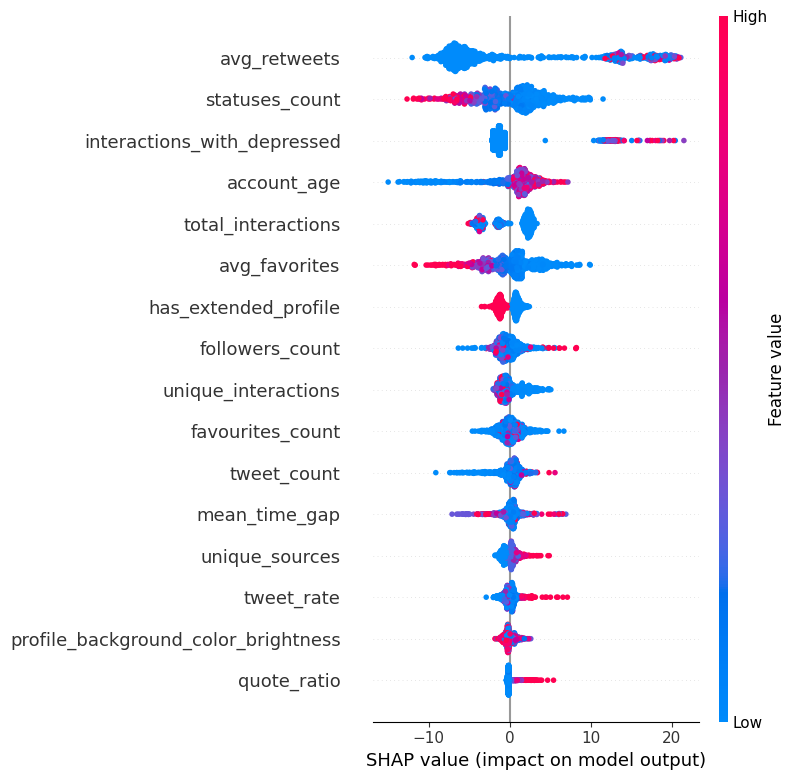

ValueError: visualize() can only display Explanation objects (or arrays of them)!

In [ ]:
# Initialize SHAP Explainer
explainer = shap.Explainer(best_model, X_train)

# Compute SHAP values
shap_values = explainer(X_test, check_additivity=False)

# Summary Plot (Global Feature Importance)
shap.summary_plot(shap_values, X_test)

# Force Plot (Local Explanation for One Instance)
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0])

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values, feature_names=X_train.columns.tolist(), class_names=["No Depression", "Depression"], mode="classification"
)

# Explain a single prediction
exp = explainer.explain_instance(X_test.iloc[0].values, best_model.predict_proba)
exp.show_in_notebook()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names



In [ ]:
# Explain a single prediction
exp = explainer.explain_instance(X_test.iloc[-1].values, best_model.predict_proba)
exp.show_in_notebook()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names

